## CS6460 data analysis

### 1. Data preparation

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

%matplotlib inline

In [71]:
causal = pd.read_excel('causal.xls')
causal = pd.DataFrame(causal)
causal.head()

,question,scale,why
0,Text,5,Because it was clear and short.
1,Charts,5,because it was good clarification
2,Text,4,it is explained in text
3,Text,4,It was the most clear.
4,Images,4,A New Powerful Experimental Tool to Improve Ch...


In [72]:
contrastive = pd.read_excel('contrastive.xls')
contrastive = pd.DataFrame(contrastive)
contrastive.head()

,question,scale,why
0,Text,5,It was the most straightforward and understand...
1,Text,5,It doesn't require me to translate.
2,Images,4,because I feel like that makes the most sense ...
3,Charts,5,I feel like the visual I chose best depicts an...
4,Text,5,I understood it the best of the 3


In [73]:
example = pd.read_excel('example.xls')
example = pd.DataFrame(example)
example.head()

,question,scale,why
0,Charts,4,good
1,Text,3,It has more details then the others.
2,Charts,4,This one shows why this shirt was the outsider...
3,Text,3,Because the other options were more difficult ...
4,Text,4,Tells us how the robot messed up


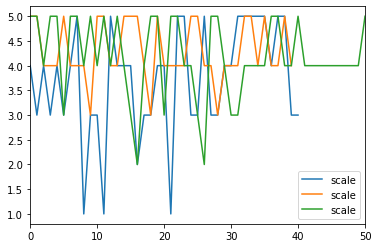

In [94]:
ax = example.plot(

)
causal.plot(ax=ax)
contrastive.plot(ax=ax)

### 2. Plot answer by scale to compare answers across all question types (contrastive, causal, example)

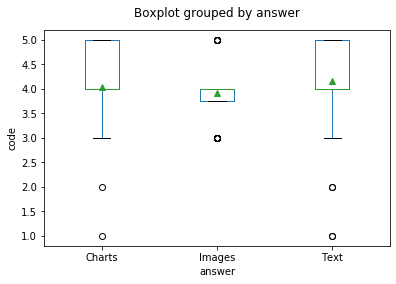

In [96]:
df.boxplot(
    column='scale',
    by='answer',
    grid=False,
    showmeans=True
)

plt.title('')
plt.ylabel('code')
plt.show()

In [41]:
df.groupby('answer').mean()

,scale
answer,
Charts,4.034483
Images,3.916667
Text,4.164179


### 3. Conduct an analysis of variance on the data to determine if there is a significant difference in mean frictions

In [95]:
# b. One-way ANOVA test to determine significance in means
formula = 'contrastive ~ example'
model = sm.formula.ols(formula, df).fit()
aov_table = sm.stats.anova_lm(model)
print(aov_table)

PatsyError: categorical data cannot be >1-dimensional